In [17]:
import pandas as pd

df = pd.read_csv('../../data/raw/census_income_dataset_original.csv')  # adjust path as needed
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  Income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


### Dropping Irrelevant Columns

The following columns are not required for ILP-based learning:
- `fnlwgt`: weighting column used for sampling, not predictive
- `education-num`: duplicate of `education`
- `capital-gain` and `capital-loss`: sparse, skewed, and mostly zero


In [19]:
df.drop(['fnlwgt', 'education-num', 'capital-gain', 'capital-loss'], axis=1, inplace=True)

In [20]:
# Checking duplicates
print(f"Duplicates before: {df.duplicated().sum()}")

# Dropping duplicates
df = df.drop_duplicates()

# Confirming removal
print(f"Duplicates Remaining after drop: {df.duplicated().sum()}")


Duplicates before: 5513
Duplicates Remaining after drop: 0


### Cleaning Text and Handle Missing Values

We:
- Convert all text to lowercase
- Strip whitespace
- Replace symbols like `?`, `NaN`, and `None` with a uniform `'unknown'`


In [21]:
# Standardizing column names
df.columns = df.columns.str.strip().str.lower().str.replace('-', '_')

# Cleaning string columns
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.strip().str.lower()
    df[col] = df[col].replace(['?', 'nan', 'na', 'none'], 'unknown')
    df[col] = df[col].str.replace('-', '_')

# Removing trailing period from income
df['income'] = df['income'].str.replace('.', '', regex=False)
df.head()

,age,workclass,education,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income
0,39,state_gov,bachelors,never_married,adm_clerical,not_in_family,white,male,40,united_states,<=50k
1,50,self_emp_not_inc,bachelors,married_civ_spouse,exec_managerial,husband,white,male,13,united_states,<=50k
2,38,private,hs_grad,divorced,handlers_cleaners,not_in_family,white,male,40,united_states,<=50k
3,53,private,11th,married_civ_spouse,handlers_cleaners,husband,black,male,40,united_states,<=50k
4,28,private,bachelors,married_civ_spouse,prof_specialty,wife,black,female,40,cuba,<=50k


### Updating Income labels

In [22]:
df['income'] = df['income'].replace({
    '<=50k': 'less_equal_50k',
    '>50k': 'greater_50k'
})
df['income'].head()

0    less_equal_50k
1    less_equal_50k
2    less_equal_50k
3    less_equal_50k
4    less_equal_50k
Name: income, dtype: object

### Discretizing `age` and `hours-per-week`

We convert continuous values into discrete bins for easier rule learning:
- `age`: young (≤30), middle (31–55), senior (>55)
- `hours-per-week`: low (<30), average (30–50), high (>50)


In [23]:
def bin_age(age):
    if age <= 30:
        return 'young'
    elif age <= 55:
        return 'middle'
    else:
        return 'senior'

def bin_hours(hours):
    if hours < 30:
        return 'low'
    elif hours <= 50:
        return 'average'
    else:
        return 'high'

df['age'] = df['age'].apply(bin_age)
df['hours_per_week'] = df['hours_per_week'].apply(bin_hours)
df.head()

,age,workclass,education,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income
0,middle,state_gov,bachelors,never_married,adm_clerical,not_in_family,white,male,average,united_states,less_equal_50k
1,middle,self_emp_not_inc,bachelors,married_civ_spouse,exec_managerial,husband,white,male,low,united_states,less_equal_50k
2,middle,private,hs_grad,divorced,handlers_cleaners,not_in_family,white,male,average,united_states,less_equal_50k
3,middle,private,11th,married_civ_spouse,handlers_cleaners,husband,black,male,average,united_states,less_equal_50k
4,young,private,bachelors,married_civ_spouse,prof_specialty,wife,black,female,average,cuba,less_equal_50k


### Grouping Native Countries into Regions

To reduce sparsity and simplify ILP rule generation, we group native countries into broader regions such as:
- North America
- Latin America
- Asia
- Europe
- Middle East
- Africa
- Unknown

In [24]:
print("🔍 Unique country names BEFORE mapping:")
print(df['native_country'].str.strip().str.lower().unique())

🔍 Unique country names BEFORE mapping:
['united_states' 'cuba' 'jamaica' 'india' 'unknown' 'mexico' 'south'
 'puerto_rico' 'honduras' 'england' 'canada' 'germany' 'iran'
 'philippines' 'italy' 'poland' 'columbia' 'cambodia' 'thailand' 'ecuador'
 'laos' 'taiwan' 'haiti' 'portugal' 'dominican_republic' 'el_salvador'
 'france' 'guatemala' 'china' 'japan' 'yugoslavia' 'peru'
 'outlying_us(guam_usvi_etc)' 'scotland' 'trinadad&tobago' 'greece'
 'nicaragua' 'vietnam' 'hong' 'ireland' 'hungary' 'holand_netherlands']


In [25]:
# Dropped south because this value looks suspicious and may have been a partial/misentered country name
df = df[df['native_country'] != 'South']

In [26]:
# Defining region lists
north_america = [c.strip().lower() for c in ['united-states', 'canada', 'puerto-rico', 'outlying-us(guam-usvi-etc)']]
latin_america = [c.strip().lower() for c in ['mexico', 'cuba', 'jamaica', 'honduras', 'el-salvador',
                 'columbia', 'guatemala', 'nicaragua', 'dominican-republic',
                 'trinadad&tobago', 'ecuador', 'haiti', 'peru']]
asia = [c.strip().lower() for c in ['india', 'china', 'japan', 'vietnam', 'philippines', 'thailand', 
        'cambodia', 'laos', 'taiwan', 'hong']]
europe = [c.strip().lower() for c in ['england', 'germany', 'italy', 'poland', 'portugal', 'france', 
          'greece', 'ireland', 'hungary', 'scotland', 'yugoslavia', 'holand-netherlands']]
middle_east = [c.strip().lower() for c in ['iran']]
africa = [c.strip().lower() for c in ['south-africa', 'egypt']]

# Defining mapping function
def map_country_to_region(country):
    if country in north_america:
        return 'north_america'
    elif country in latin_america:
        return 'latin_america'
    elif country in asia:
        return 'asia'
    elif country in europe:
        return 'europe'
    elif country in middle_east:
        return 'middle_east'
    elif country in africa:
        return 'africa'
    else:
        return 'unknown'

# Applying mapping
df['native_country'] = df['native_country'].apply(map_country_to_region)


### Stratified Sampling

To ensure balanced examples for ILP learning, we take an equal number of rows from each class (`<=50K` and `>50K`) for a representative sample. We take 500 balanced rows (250 from each class)


In [27]:
df_sample = df.groupby('income', group_keys=False).apply(lambda x: x.sample(min(250, len(x)), random_state=42))

df_sample = df_sample.reset_index(drop=True)

df_sample['income'].value_counts()

greater_50k       250
less_equal_50k    250
Name: income, dtype: int64

### Exploratory Data Analysis (EDA)

##### 1. Target variable distribution

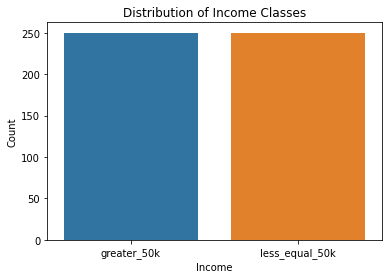

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizing income distribution
sns.countplot(x='income', data=df_sample)
plt.title('Distribution of Income Classes')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()


Observation:
The income classes are evenly distributed in the sampled dataset, with 250 rows each for `<=50k` and `>50k`. This stratified sampling ensures that the ILP system receives a balanced set of positive and negative examples.


##### 2. Distribution of categorical features

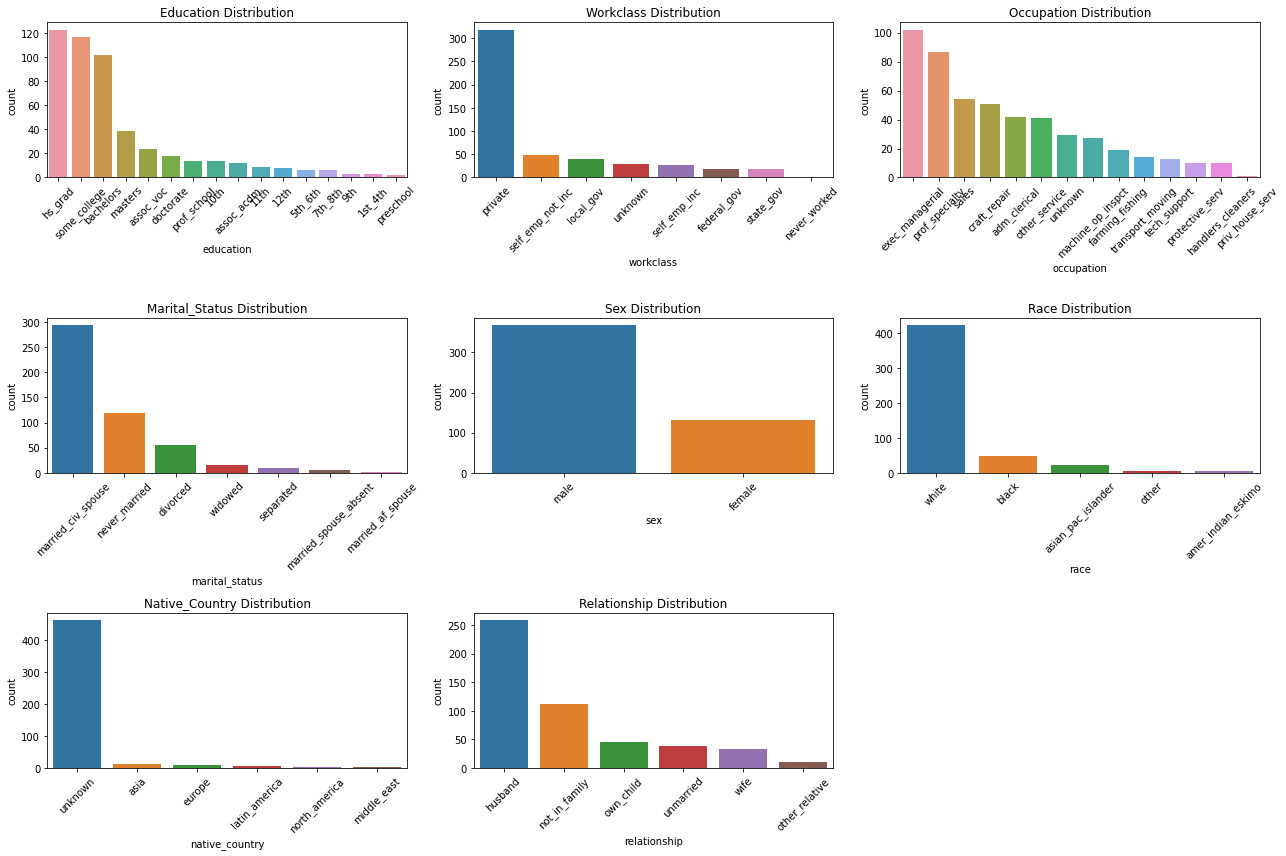

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = ['education', 'workclass', 'occupation', 'marital_status', 'sex', 'race', 'native_country', 'relationship']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df_sample, ax=axes[i], order=df_sample[col].value_counts().index)
    axes[i].set_title(f'{col.title()} Distribution')
    axes[i].tick_params(axis='x', rotation=45)

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


Observation:
1. Education is dominated by levels like 'hs-grad', 'some-college', and 'bachelors', while very few individuals have 'preschool' or '1st-4th' education.

2. Workclass shows 'private' as the most common category, followed by 'self-employed' and 'government' roles.

3. In occupation, technical, administrative, and managerial jobs appear most frequently, while categories like 'armed-forces' are extremely rare.

4. Marital status is primarily 'married' and 'never-married', aligning with a typical working-age population.

5. Sex distribution shows more males than females in this sample.

6. Race is skewed towards 'white', with other races making up a small portion.

7. Native country is heavily concentrated in the 'united-states', making other countries sparse — a good case for grouping into regions or using 'other'.

8. Relationship status is mostly 'husband' and 'not-in-family', likely reflecting primary household earners or individuals living alone.

##### 2. Distribution of age and hours_per_week

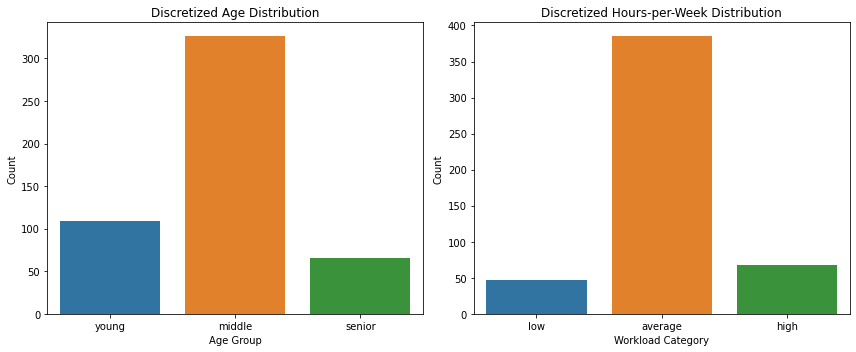

In [30]:
# Plotting distributions of binned numerical features
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Age bin distribution
sns.countplot(x='age', data=df_sample, order=['young', 'middle', 'senior'], ax=axes[0])
axes[0].set_title('Discretized Age Distribution')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Count')

# Hours-per-week bin distribution
sns.countplot(x='hours_per_week', data=df_sample, order=['low', 'average', 'high'], ax=axes[1])
axes[1].set_title('Discretized Hours-per-Week Distribution')
axes[1].set_xlabel('Workload Category')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


Observation:
1. The `age` variable shows a majority of individuals in the **middle** age range (31–55), followed by **young** (≤30) and fewer in the **senior** category (>55).
2. The `hours-per-week` variable is also well-distributed, with most individuals working an **average** number of hours (30–50). Very few individuals fall in the **high** or **low** workload groups.
3. This confirms that binning has worked as expected and the categories are reasonably balanced for rule learning in ILP.


In [31]:
df.to_csv('../../data/processed/processed_ilp_aleph_dataset.csv', index=False)